# Environmental contour

Brief example that computes a sea state contour from the PNBOIA data (https://www.marinha.mil.br/chm/dados-do-goos-brasil/pnboia-mapa) using the Library virocon (https://github.com/virocon-organization/virocon).

A contour implements a method to define multivariate extremes based on a joint probabilistic model of variables 
like significant wave height, wind speed or spectral peak period. Contour curves or surfaces for more than two 
environmental parameters give combination of environmental parameters which approximately describe the various 
actions corresponding to the given exceedance probability. See: 
https://virocon.readthedocs.io/en/latest/definitions.html

### Python code

Import the required packages.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import csv
import os
import datetime
import numpy as np
from virocon import (
    read_ec_benchmark_dataset,
    get_OMAE2020_Hs_Tz,
    GlobalHierarchicalModel,
    IFORMContour,
    IFORMContour,
    ISORMContour,
    DirectSamplingContour,
    HighestDensityContour,
    plot_2D_contour,
)

Define the contour’s return period **tr**, environmental state duration **ts** and number of points **nSamples** for the simulations.

In [2]:
# Return period in years. Describes the average time period between two consecutive environmental states 
# that exceed a contour. In the univariate case the contour is a threshold.
tr = 50
# Sea state duration in hours. Time period for which an env
ts = 1
# Number of sea states for simulation
nSamples = 5

Donwload a buoy sea state data set from https://www.marinha.mil.br/chm/dados-do-goos-brasil/pnboia-mapa

Set the **input file name** with buoy data. Here, we use a dataset from BOIA SANTOS.

In [3]:
inpute_file_name = 'historico_santos' # Buoy File name - Buoy SANTOS 25°26'37''S 45°02'17''W

Read data and delete negative values.

In [4]:
input_file_txt = inpute_file_name + '.txt'

# Output CSV file name formatted to be used with virocon functions
output_file_csv = inpute_file_name + '_comma.csv'
# Output TXT file name formatted to be used with virocon functions
output_file_txt = inpute_file_name + '_comma.txt'

# Wvht: significant wave height (m)
# Dpd:  peak wave period (s)
df = pd.read_csv(input_file_txt, sep=',', usecols=['# Datetime', 'Wvht', 'Dpd'])

# Delete negative values
df = df.drop(df.index[df['Wvht'] < 0])
df = df.drop(df.index[df['Dpd'] < 0])

print(df)

                # Datetime  Wvht   Dpd
0      2011-04-12 19:00:00  1.62  11.1
1      2011-04-12 20:00:00  1.62   6.9
2      2011-04-12 21:00:00  1.63   6.9
3      2011-04-12 22:00:00  1.57  11.8
4      2011-04-12 23:00:00  1.47   6.7
...                    ...   ...   ...
59489  2018-12-09 04:00:00  3.61  14.3
59490  2018-12-09 05:00:00  3.27  14.3
59491  2018-12-09 06:00:00  3.61  14.3
59492  2018-12-09 07:00:00  3.19  14.3
59493  2018-12-09 08:00:00  3.46  14.3

[56110 rows x 3 columns]


Prepare data to be used by virocon.

In [5]:
# Convert datetime format
dfAux = []
for index, row in df.iterrows():
    timeSTP = pd.Timestamp(row['# Datetime'])
    dfAux.append(timeSTP.strftime('%Y-%m-%d-%H'))

# Creating DataFrame
d2 = {'# Datetime':dfAux}
df2 = pd.DataFrame(d2)
# Assigning column of df2 to a new column of df
df['# Datetime'] = df2['# Datetime']

row_count = df.shape[0] # Returns number of rows
col_count = df.shape[1] # Returns number of columns
print('Number of valid data', row_count)

# Save temp file
df.to_csv('temp.txt',index=False)

# Rename Header Columns in CSV File
with open('temp.txt', 'r', encoding='utf-8') as file:
    data = file.readlines()
data[0] = 'time (YYYY-MM-DD-HH),significant wave height (m),zero-up-crossing period (s)\n'
with open('temp.txt', 'w', encoding='utf-8') as file:
    file.writelines(data)

# Check if ouputfile already exists, then delete it:
if os.path.exists(output_file_csv):
    os.remove(output_file_csv)

# Renaming the file
os.rename('temp.txt', output_file_csv)

# Load sea state measurements. 
df = pd.read_csv(output_file_csv, index_col=0)

# Remove Rows with empty cells
new_df = df.dropna()

# Save as txt file without column ID and using semicolons
new_df.to_csv(output_file_txt, sep=';')

print('Input file successfully changed to be used with package virocon')

Number of valid data 56110
Input file successfully changed to be used with package virocon


Load the sea state data set.

In [6]:
data = read_ec_benchmark_dataset(output_file_txt)

Define the structure of the joint distribution model.

In [7]:
dist_descriptions, fit_descriptions, semantics = get_OMAE2020_Hs_Tz()
model = GlobalHierarchicalModel(dist_descriptions)

Estimate the model's parameter values (fitting).

In [8]:
model.fit(data, fit_descriptions=fit_descriptions)

Compute IFORM and ISORM contours with a return period of **tr** years.
- IFORM: inverse first-order reliability method
- ISORM: inverse second-order reliability method. More conservative

In [9]:
alpha = 1.0 / (tr * 365.25 * 24.0 / ts)

In [10]:
iform_contour = IFORMContour(model, alpha)

In [11]:
isorm_contour = ISORMContour(model, alpha)

Select **nSamples** points.

In [12]:
waveHeight = iform_contour.coordinates[:,0]
wavePeriod = iform_contour.coordinates[:,1]

# Number of points
nPts = waveHeight.size
# Interval of 5 points
intPts = int(nPts/nSamples)
# Maximum wave height (n-year significant wave height, Hs,n), index and respective period
maxH = np.amax(waveHeight)
maxHid = np.argmax(waveHeight)
maxHperiod = wavePeriod[maxHid]

# a_ = np.sqrt(6.5) # 3.54
# b_ = np.sqrt(11.0) # 4.56
# T1 = a_ * np.sqrt(maxH)
# T2 = b_ * np.sqrt(maxH)
# print('T1: ', T1)
# print('T2: ', T2)

# Minimum wave period, index
minT = np.amin(wavePeriod)
minTid = np.argmin(wavePeriod)
# Maximum wave period, index and respective height
maxT = np.amax(wavePeriod)
maxTid = np.argmax(wavePeriod)
maxTheight = waveHeight[maxHid]

# Period interval
periodInt = (maxT - minT)/nSamples
# periodInt = (maxT - maxHperiod)/2.0

print('Interval period Tint: ', periodInt)
print('Period of the maximum wave height MaxHT: ', maxHperiod)

ids = []
# Return index
# Search right points
for ii in range(1, nSamples):
    if ii > nSamples/2:
        break
    idAux1 = np.where(np.logical_and(wavePeriod > maxHperiod + (ii - 0.05)*periodInt, wavePeriod < maxHperiod + (ii + 0.05)*periodInt))
    # idAux1 = np.where(np.logical_and(wavePeriod > 0.95*T1, wavePeriod < 1.05*T1))
    # Find max Height for the period
    maxHaux = 0
    for jj in idAux1[0]:
        if waveHeight[jj] > maxHaux:
            maxHaux = waveHeight[jj]
            idMaxH = jj
    ids.append(idMaxH)

del ii

# Search left point
for ii in range(1, nSamples):
    if ii > nSamples/2:
        break
    idAux2 = np.where(np.logical_and(wavePeriod > maxHperiod - (ii + 0.05)*periodInt, wavePeriod < maxHperiod - (ii - 0.05)*periodInt))
    # idAux2 = np.where(np.logical_and(wavePeriod > 0.95*T2, wavePeriod < 1.05*T2))
    # Find max Height for the period
    maxHaux = 0
    for jj in idAux2[0]:
        if waveHeight[jj] > maxHaux:
            maxHaux = waveHeight[jj]
            idMaxH = jj
    ids.append(idMaxH)

wavePts = []
wavePts.append(waveHeight[0])
for xx in ids:
    wavePts.append(waveHeight[xx])
# wavePts.append(waveHeight[maxTid])
periodPts = []
periodPts.append(wavePeriod[0])
del xx
for xx in ids:
    periodPts.append(wavePeriod[xx])
# periodPts.append(wavePeriod[maxTid])

periodOutput = ['{:.2f}'.format(elem) for elem in periodPts]
waveOutput = ['{:.2f}'.format(elem) for elem in wavePts]
print('Wave Periods[s]: ', periodOutput)
print('Wave heights[m]: ', waveOutput)

Interval period Tint:  4.947125076084516
Period of the maximum wave height MaxHT:  15.0875875205887
Wave Periods[s]:  ['15.09', '19.85', '24.92', '10.28', '5.24']
Wave heights[m]:  ['9.03', '6.24', '2.89', '7.09', '3.42']


Plot the contours and save the figure.

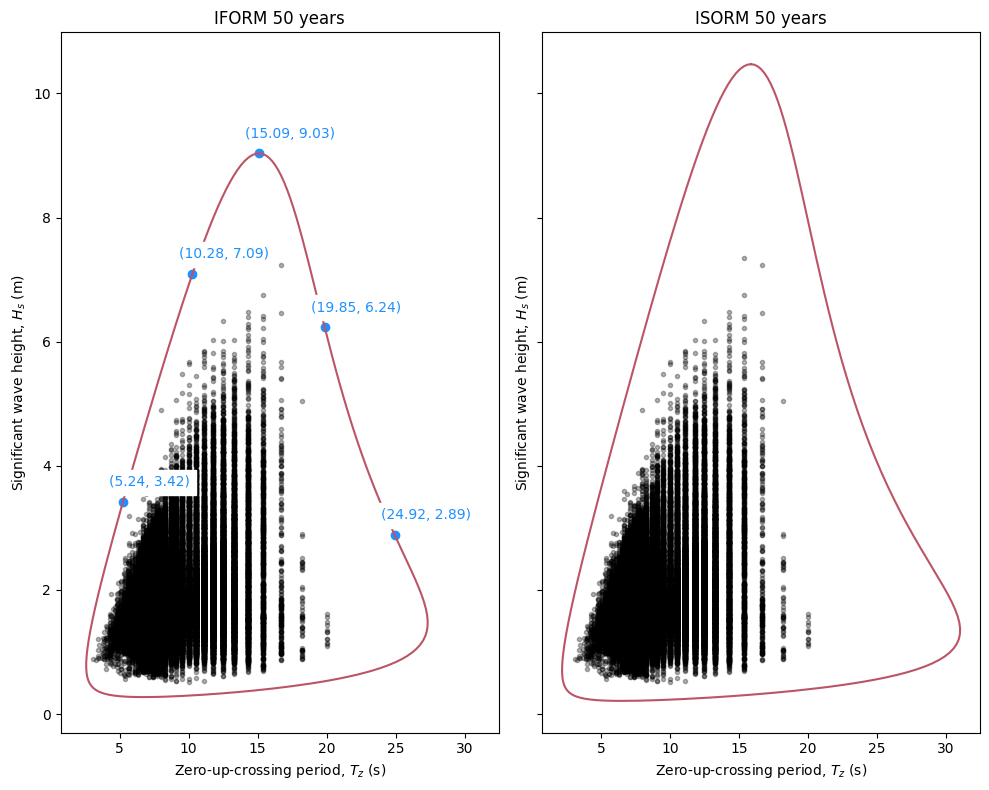

Figure saved in folder 'figures'


In [13]:
plots_n = []
# Plot the contour
fig, axs = plt.subplots(1, 2, figsize=[10, 8], sharex=True, sharey=True)
# fig, axs = plt.subplots(1, 2, figsize=[10, 8], sharex=True, sharey=True, gridspec_kw={'width_ratios': [1000, 1]})
plot_2D_contour(iform_contour, data, semantics=semantics, ax=axs[0], swap_axis=True)
plot_2D_contour(isorm_contour, data, semantics=semantics, ax=axs[1], swap_axis=True)
axs[0].scatter(periodPts, wavePts, color='dodgerblue') # royalblue
for ii, jj in zip(periodPts, wavePts):
    iiText = '{:.2f}'.format(ii)
    jjText = '{:.2f}'.format(jj)
    axs[0].text(ii-1.0, jj+0.25, '({}, {})'.format(iiText, jjText), backgroundcolor='w', color='dodgerblue') # royalblue

titles = ['IFORM ' + str(tr) + ' years', 'ISORM ' + str(tr) + ' years']
for i, (ax, title) in enumerate(zip(axs, titles)):
    ax.set_title(title)
plt.tight_layout()

fig = plt.gcf() # get current figure

# Make directory
fig_directory_name = 'figures'
current_directory = os.getcwd()
final_directory = os.path.join(current_directory, fig_directory_name)
if not os.path.exists(final_directory):
    os.makedirs(final_directory)

# Save Figure
fig_name = inpute_file_name + '_tr' + str(tr) + 'years_envirom_countor'
fig.savefig(fig_directory_name + '/' + fig_name + '.png')
plt.show()
plt.close(fig)    # close the figure window

print('Figure saved in folder \'{}\''.format(fig_directory_name))